# AML — Task 1
## Predict the age of a brain from MRI features
---

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.neighbors import LocalOutlierFactor

---
## Function definition

---
### Load datasets

In [55]:
def load_raw_data():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

---
### Export datasets

In [56]:
def export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned):
    X_train_cleaned.to_csv('data/X_train_cleaned.csv', index=False)
    y_train_cleaned.to_csv('data/y_train_cleaned.csv', index=False)
    X_test_cleaned.to_csv('data/X_test_cleaned.csv', index=False)

---
### Outlier detection

In [57]:
def remove_outliers(X_train, y_train, contamination='auto', verbose=1):
    """
    Remove the ouliers from our dataset. Temporarily replace the nan values by 
    the median to perform the outlier detection.

    Parameters
    ----------
    X_train : pd.df
        The features (what we will use to see the outliers)
    y_train : pd.df
        The labels
    contamination : int, optional
        The percent of outliers found by the isolation forest if it is used.

    Return
    ------
    (pd.df, pd.df)
        The data with the outliers rows removed
    """
    # Save a mask of the imputed values to be able to redo the imputation once the outlier detection is done
    X_train_null_mask = X_train.isna()
    
    # Need to impute nan values for the outlier detection to work (cannot deal with nan)
    X_train_imputed = pd.DataFrame(SimpleImputer(strategy="median", verbose=verbose).fit_transform(X_train))
    
#     clf = IsolationForest(contamination=contamination, random_state=0) # modify here
    clf = LocalOutlierFactor(contamination=contamination) # modify here
    outliers_mask = pd.Series(clf.fit_predict(X_train_imputed))
    
    if verbose:
        print(f"Detected {(outliers_mask == -1).sum()} outliers, out of {outliers_mask.shape[0]} samples ({100 * (outliers_mask == -1).sum() / outliers_mask.shape[0]:.2f}%).")
    
    # Put back the nan values
    # convert the null mask to np.array so it is correctly applied since X_train indexes have changed
    X_train_no_outliers = X_train_imputed.mask(np.array(X_train_null_mask))
    
    # Remove outliers from the training set
    X_train_no_outliers = X_train_no_outliers.loc[outliers_mask == 1, :]
    y_train_no_outliers = y_train.loc[outliers_mask == 1, :]
    
    return (X_train_no_outliers, y_train_no_outliers)

---
### Data scaling
Should be done as soon as possible because can have an effect (e.g. on distances for `KNNImputer`)

In [58]:
def scale(X_train, X_test):
    # Do the scaling, saving the scaler to use it for X_test too. No need for imputation, just ignore nan values.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train))
    # Cast X_test to np.array to avoid warning of model trained without feature names but X having some.
    X_test_scaled = pd.DataFrame(scaler.transform(np.array(X_test)))
    return (X_train_scaled, X_test_scaled)

---
### Imputation of values

In [59]:
def impute_values(X_train, X_test, method='knn'):
    print(f"For the train dataset, there are {np.array(X_train.isna()).sum().sum()} nan values, out of {X_train.shape[0]*X_train.shape[1]} ({100*np.array(X_train.isna()).sum().sum()/(X_train.shape[0]*X_train.shape[1]):.2f}%).")
    
    imputer = None
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train)
    elif method == 'iterative':
        # Runs VERY slowly
        imputer = IterativeImputer(random_state=0, verbose=2).fit(X_train)
    
    X_train_imputed = pd.DataFrame(imputer.transform(X_train))
    X_test_imputed = pd.DataFrame(imputer.transform(X_test))
    return (X_train_imputed, X_test_imputed)

---
### Feature selection

In [60]:
def select_features(X_train, y_train, X_test):
    X_train_selected_features, X_test_selected_features = remove_constant_features(X_train, X_test)
    X_train_selected_features, X_test_selected_features = remove_too_correlated_features(X_train_selected_features, X_test_selected_features)
    X_train_selected_features, X_test_selected_features = remove_random_features(X_train_selected_features, y_train, X_test_selected_features, percentile=80)
    
    return X_train_selected_features, X_test_selected_features

In [61]:
def remove_constant_features(X_train, X_test, verbose=1):
    X_train_selected_features = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
    X_test_selected_features = X_test.loc[:, (X_train != X_train.iloc[0]).any()]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of constant values ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")
    
    return X_train_selected_features, X_test_selected_features

In [62]:
def remove_too_correlated_features(X_train, X_test, threshold=0.7, verbose=1):
    X_train_corr_ = X_train.corr()

    X_train_too_correlated = (X_train_corr_.mask(
        np.tril(np.ones([len(X_train_corr_)]*2, dtype=bool))).abs() > threshold).any()
    
    X_train_selected_features = X_train.loc[:, (~X_train_too_correlated)]
    X_test_selected_features = X_test.loc[:, (~X_train_too_correlated)]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of correlation > {threshold} ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")

    return X_train_selected_features, X_test_selected_features

In [80]:
def remove_random_features(X_train, y_train, X_test, Xtrm, Xtem, percentile=80, verbose=1):
    selector = SelectPercentile(f_regression, percentile=percentile) # modify here
    selector.fit(X_train, np.array(y_train).ravel())
    X_train_selected_features = pd.DataFrame(selector.transform(X_train))
    X_test_selected_features = pd.DataFrame(selector.transform(X_test))
    Xtrm_selected_features = pd.DataFrame(selector.transform(Xtrm))
    Xtem_selected_features = pd.DataFrame(selector.transform(Xtem))
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of low correlation with target ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")
        
    return X_train_selected_features, X_test_selected_features, Xtrm_selected_features, Xtem_selected_features

---
### Models

In [83]:
def best_lasso(X_train, y_train):
    lasso = Lasso(max_iter=100000)
    gs_lasso_params = {
        'alpha': np.logspace(-2, 0, 20),
    }
    gs_lasso = GridSearchCV(lasso, gs_lasso_params, cv=5, verbose=3)
    gs_lasso.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_lasso.best_score_:.5f} with\n\talpha: {gs_lasso.best_params_['alpha']}")
    
    return gs_lasso

In [65]:
def best_svr(X_train, y_train):
    svr = SVR()
    gs_svr_params = {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-1, 2.2, 4),
        'epsilon': np.logspace(-2, 1, 3),
    }
    gs_svr = GridSearchCV(svr, gs_svr_params, cv=5, verbose=3)
    gs_svr.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svr.best_score_:.5f} with
    \tkernel: {gs_svr.best_params_['kernel']}
    \tC: {gs_svr.best_params_['C']}
    \tepsilon: {gs_svr.best_params_['epsilon']}""")
    
    return gs_svr

In [78]:
def best_gbr(X_train, y_train):
#     gbr = GradientBoostingRegressor(random_state=0)
#     gs_gbr_params = {
#         "learning_rate": np.logspace(-3, -1, 3),
#         "n_estimators": np.logspace(1, 3, 3),
#         "subsample": [0.7, 1],
#         "max_depth": [3, 4, 5],
#     }
#     gs_gbr = GridSearchCV(gbr, gs_gbr_params, cv=5, verbose=3, error_score='raise')
#     gs_gbr.fit(X_train, y_train)
#     return gs_gbr

    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
        "random_state": 0, 
        "verbose": 1,
    }

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    gbr = GradientBoostingRegressor(**params)
    gbr.fit(X_train, y_train)
    
    print(f"Score is {gbr.score(X_test, y_test):.4f}.")
    
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(gbr.staged_predict(X_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        gbr.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()
    
    return gbr

---
### Submission file

In [67]:
def create_submission(prediction, sub_id, basepath='submissions/task1-sub'):
    result = prediction.copy()
    result = result.rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

---
## Run pipeline

---
### Data preprocessing

In [68]:
# print("Loading raw data...")
# X_train, y_train, X_test = load_raw_data()

# print("Removing outliers...")
# X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

# print("Scaling data...")
# X_train_scaled, X_test_scaled = scale(X_train_no_outliers, X_test)

# print("Imputing nan values...")
# X_train_imputed, X_test_imputed = impute_values(X_train_scaled, X_test_scaled, method=knn')

# print("Selecting features...")
# X_train_selected_features, X_test_selected_features = select_features(X_train_imputed, y_train_no_outliers, X_test_imputed)

# print("Exporting clean data to csv...")
# X_train_cleaned, y_train_cleaned, X_test_cleaned = X_train_selected_features, y_train_no_outliers, X_test_selected_features
# export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned)

# print("All done!")

In [81]:
print("Loading raw data...")
X_train, y_train, X_test = load_raw_data()

print("Removing outliers...")
X_train, y_train = remove_outliers(X_train, y_train)

print("Scaling data...")
X_train, X_test = scale(X_train, X_test)

print("Selecting features...")
X_train, X_test = remove_constant_features(X_train, X_test)
X_train, X_test = remove_too_correlated_features(X_train, X_test)

#TODO: Clean pipeline
# If we want iterative imputation, and don't want to run it for one hour (should try at one point though), need to
# do feature selection before we do imputation. Except biggest filter for feature selection is f_regression which
# cannot deal with nan values. Therefore, intermediary dumb knn imputation was quickly/dirtily 
# implemented to see results.
# Conclusion: we achieve ~same or better validation scores with a LOT less features, seems like an 
# interresting way forward (even though test scores are a bit lower once submitted, but to not 
# overfit on the public ones and fail on the secret ones, should only watch validation score)
X_train_mask = X_train.isna()
X_test_mask = X_test.isna()
X_train, X_test = impute_values(X_train, X_test, method='knn')
X_train, X_test, X_train_mask, X_test_mask = remove_random_features(X_train, y_train, X_test, X_train_mask, X_test_mask, percentile=30)
X_train = X_train.mask(np.array(X_train_mask))
X_test = X_test.mask(np.array(X_test_mask))

print("Imputing nan values...")
X_train, X_test = impute_values(X_train, X_test, method='iterative')

print("Exporting clean data to csv...")
export_to_csv(X_train, y_train, X_test)

print("All done!")

Loading raw data...
Removing outliers...
Detected 50 outliers, out of 1212 samples (4.13%).
Scaling data...
Selecting features...
0 features removed because of constant values (0.00%)
146 features removed because of correlation > 0.7 (17.55%)
For the train dataset, there are 60781 nan values, out of 797132 (7.62%).


/Users/antoine/miniconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


480 features removed because of low correlation with target (69.97%)
Imputing nan values...
For the train dataset, there are 18108 nan values, out of 239372 (7.56%).
[IterativeImputer] Completing matrix with shape (1162, 206)
[IterativeImputer] Ending imputation round 1/10, elapsed time 5.68
[IterativeImputer] Change: 24.54097752758862, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 2/10, elapsed time 11.38
[IterativeImputer] Change: 1.8333972078591216, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 3/10, elapsed time 17.52
[IterativeImputer] Change: 0.2782159738102602, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 4/10, elapsed time 23.12
[IterativeImputer] Change: 0.13795426292901322, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 5/10, elapsed time 29.29
[IterativeImputer] Change: 0.0684152493362627, scaled tolerance: 0.013896992902987433 


---
### Model training

In [84]:
lasso = best_lasso(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........................alpha=0.01;, score=0.460 total time=   0.1s
[CV 2/5] END ........................alpha=0.01;, score=0.455 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.452 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.460 total time=   0.0s
[CV 5/5] END ........................alpha=0.01;, score=0.392 total time=   0.0s
[CV 1/5] END ........alpha=0.012742749857031334;, score=0.461 total time=   0.0s
[CV 2/5] END ........alpha=0.012742749857031334;, score=0.456 total time=   0.0s
[CV 3/5] END ........alpha=0.012742749857031334;, score=0.454 total time=   0.0s
[CV 4/5] END ........alpha=0.012742749857031334;, score=0.463 total time=   0.0s
[CV 5/5] END ........alpha=0.012742749857031334;, score=0.394 total time=   0.0s
[CV 1/5] END ........alpha=0.016237767391887217;, score=0.463 total time=   0.0s
[CV 2/5] END ........alpha=0.016237767391887217

In [85]:
svr = best_svr(X_train, np.array(y_train).ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.045 total time=   0.1s
[CV 2/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.037 total time=   0.1s
[CV 3/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.028 total time=   0.1s
[CV 4/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.030 total time=   0.1s
[CV 5/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.010 total time=   0.1s
[CV 1/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.098 total time=   0.1s
[CV 2/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.076 total time=   0.1s
[CV 3/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.078 total time=   0.1s
[CV 4/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.089 total time=   0.1s
[CV 5/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.077 total time=   0.1s
[CV 1/5] END C=0.1, epsilon=0.01, kernel=sigmoid;, score=0.271 total time=   0.1s
[CV 2/5] END C=0.1, epsilon=0.01, kernel=sigmo

[CV 1/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.426 total time=   0.1s
[CV 2/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.296 total time=   0.1s
[CV 3/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.318 total time=   0.1s
[CV 4/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.286 total time=   0.1s
[CV 5/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.287 total time=   0.1s
[CV 1/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.607 total time=   0.2s
[CV 2/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.497 total time=   0.2s
[CV 3/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.506 total time=   0.2s
[CV 4/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.533 total time=   0.2s
[CV 5/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.537 total time=   0.2s
[CV 1/5] END C=13.593563908785255, epsilon=0.01, kernel=sigmoid;,

[CV 3/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.397 total time=   0.1s
[CV 4/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.360 total time=   0.0s
[CV 5/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.395 total time=   0.0s
[CV 1/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-1323.668 total time=   0.2s
[CV 2/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-2825.587 total time=   0.2s
[CV 3/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-737.958 total time=   0.2s
[CV 4/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-525.466 total time=   0.1s
[CV 5/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-915.087 total time=   0.2s
The best validation score obtained is 0.53584 with
    	kernel: rbf
    	C: 13.593563908785255
    	epsilon: 0.01


      Iter       Train Loss   Remaining Time 
         1          96.1383           31.17s
         2          95.0618           28.76s
         3          94.0136           27.93s
         4          92.9759           27.85s
         5          91.9499           27.86s
         6          90.9605           27.42s
         7          89.9814           27.03s
         8          89.0215           27.23s
         9          88.0802           27.07s
        10          87.1464           26.79s
        20          78.7616           27.38s
        30          71.5699           26.74s
        40          65.4768           25.80s
        50          60.1468           24.98s
        60          55.4013           24.27s
        70          51.1510           23.58s
        80          47.4010           22.94s
        90          44.0601           22.33s
       100          41.0734           21.73s
       200          23.7403           16.02s
       300          15.9482           10.77s
       40

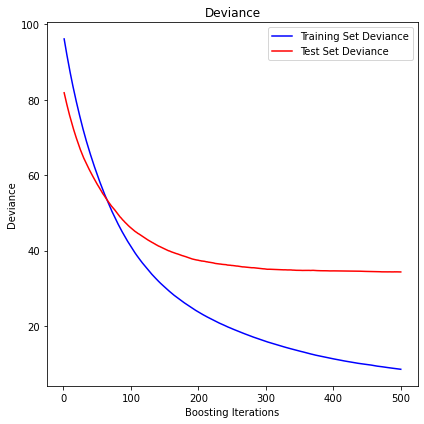

In [86]:
#TODO: could not manage to get CV to work with this, should look into it as there are a lot of
# hyperparameters at play
gbr = best_gbr(X_train, np.array(y_train).ravel())

---
### Creation of the submission file

In [87]:
prediction = pd.DataFrame(gbr.predict(X_test)) # modify here
sub_id = 10 # modify here
create_submission(prediction, sub_id)

Link where to submit: https://aml.ise.inf.ethz.ch/task1/#submission